<a href="https://colab.research.google.com/github/AlejandroBeltranA/Insight-Crime-Classifier/blob/master/Insight_Crime_ML_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Insight Crime Text Classifier

This script uses news articles scraped from https://www.insightcrime.org/category/news/ to build a text classifier. Each article contains a variety of tags that classify what the main topic of each article is, we exploit these tags to train a model with minimal external classification. 



Mount your google drive so that the script can access the file used in this script. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
%cd /content/drive/
!ls


/content/drive
'My Drive'


In [ ]:
import pandas as pd

Let's read in the csv file created from the spider crawl. Make sure encoding is utf-8 and we are dropping rows with no observations. 

In [ ]:
df = pd.read_csv('My Drive/Data/Insight Crime/models/data/InsightCrime_News.csv', encoding='utf-8').dropna()


Here's a preview of the data frame. Includes author, content, date, tags, title, type, and url. 

In [ ]:
df = df.drop(['author', 'date', 'url', 'type'], axis=1)


In [ ]:
df

,content,tags,title
0,Protests broke out in Bolivia last year in the...,"Bolivia,Cocaine,Elites and Organized Crime,Inf...",Bolivia Investigations Target Members of Evo M...
1,Increased security of containers entering the ...,"Brazil,Cocaine,European Organized Crime,Securi...",Can Port of Antwerp Truly Stem Cocaine Enterin...
2,The sight of children bearing arms in Guerrero...,"Homicides,Mexico",Los Ardillos Continue Terrorizing Indigenous C...
3,Helena is one of the many former FARC members ...,"Colombia,FARC,FARC peace,Gender and Organized ...",Former FARC Guerrillas Recognized as Victims o...
4,"Luis Del Río Jiménez, alias “el Tío,” or “Seño...","Colombia,Elites and Organized Crime",Was ‘Señor T’ One of Colombia’s Invisible Drug...
...,...,...,...
15764,SHARE\nLa captura de Daniel “El Loco” Barrera ...,"El Loco Barrera,Venezuela",El arresto del ‘Loco Barrera’ muestra a Venezu...
15765,SHARE\nEl informe\nelaborado por el inspector ...,"Frontera EU/México,Tráfico de armas",Veredicto sobre la Operación ‘Rápido y Furioso’
15766,SHARE\nFalsos periodistas de la cadena Televis...,"Costa Rica,Lavado de dinero,Nicaragua",Falsos Periodistas Acusados por los Delitos de...
15767,"SHARE\nEn lo corrido del año, la Secretaría de...",México,Aproximadamente 8.000 Detenidos por Narcotráfi...


General list of modules we'll be using. 

In [ ]:

import pandas as pd
import numpy as np
import json
import nltk
import re
import csv
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


The original tags in Insight Crime have a lot of overlap between languages and across topics. So instead of having different tags for "El Chapo", "Cartel de Sinaloa", and "Sinaloa Cartel" we reclassify them all to "Cartel de Sinaloa" thus reducing the number of overrall tags. Also, countries appear in English and Spanish spelling, we centralize these to English. The actions were also recoded to be consistent across languages. 

Read in the reclassified tags. 

In [ ]:
data = pd.read_csv('My Drive/Data/Insight Crime/models/data/reclassified_tags.csv', encoding='latin-1').fillna("")
data = data.drop(['Count', 'Unsure'], axis=1)
data

,Original,Revised
0,Colombia,Colombia
1,Mexico,Mexico
2,El Salvador,El Salvador
3,México,Mexico
4,Guatemala,Guatemala
...,...,...
248,Antonio García,ELN
249,El Doctor,
250,Hector Beltran Leyva,Organización Beltrán Leyva
251,Grupos de Perú,


In [ ]:
#for row in data.itertuples():
#  og = row.Original
#  og = str(og)        #"'"+og+"'"
#  newnew = row.Revised
#  newnew = str(newnew)  #"'"+newnew+"'"
#  df['tags'] = df['tags'].str.replace(og , newnew)
#df
# This was close to working but I couldn't get the regex right so it would replace the whole word. 

In [ ]:
df['tags'][1]

'Brazil,Cocaine,European Organized Crime,Security Policy,Suriname'

## Revised Tags
The goal is to take the tags from the "Original" column and replace those with the "Revised" tags. Below, I go row by row reviewing the contents in the "tags" column of the Insight data. I ask it to search for keywords from the "Original" column and then create a new column named "new_tags" where we store the revised tag for each word. og is the original tag, newnew is the revised tag. I was having issues with empty tuples so I added conditions that resolve this issue. The if not command confirms whether the tuple is empty or not. This process is slow, I imagine there is a way to speed this up by not looping through itertuples.

In [ ]:
corpus = []
# Let's go row by row in the insight crime data. This is slow, but it works. 
for i in df.itertuples():
  tags = i.tags # the tags assigned by insight crime
  text = i.content # the content of each article
  title = i.title # the title of each article
  new_t = [] # Generate empty list and empty tuple where we will store matches
  new_tags = ()
  for row in data.itertuples():
    og = row.Original # Now I am pulling the original tag from each row on the reclassified_tags csv. 
    og = r"\b"+og+r"\b" # I am regexing it to only select the full word.
    match = re.findall(og, tags) # Search for the tag in the tags column
    newnew = row.Revised # Let's save the new revised tag
    if not newnew: # If we did not assign a new revised tag, let's skip it. 
      continue
    else:
      for matches in match: # But if there is a tag, let's save these new tags.
        new_t.append(newnew)
        new_tags = ','.join(new_t)
  if not new_tags: #If absolutely no tags were found for an article we want to tag it as empty. 
    new_tags = "Empty"
  else:
    new_tags = new_tags
  corpus.append({'content': text , 'title': title, 'new_tags': new_tags, 'tags': tags})


I was having problems with articles that had no new tags. For example, soccer crime was never assigned a new category so this category was dropped. Articles that were tagged as soccer crime where then reclassified as "Empty" in the code above. Here I test out how that process works. 

In [ ]:
  new_tags = ("Chips")
  if not new_tags: #If absolutely no tags were found for an article we want to tag it as empty. 
    new_tags = "Empty"
  else:
    print (new_tags)

Chips


In [ ]:
dta = pd.DataFrame(corpus)
dta

,content,title,new_tags,tags
0,Protests broke out in Bolivia last year in the...,Bolivia Investigations Target Members of Evo M...,"Corruption,Bolivia,Drug trafficking","Bolivia,Cocaine,Elites and Organized Crime,Inf..."
1,Increased security of containers entering the ...,Can Port of Antwerp Truly Stem Cocaine Enterin...,"Brazil,Law Enforcement,Drug trafficking,Suriname","Brazil,Cocaine,European Organized Crime,Securi..."
2,The sight of children bearing arms in Guerrero...,Los Ardillos Continue Terrorizing Indigenous C...,"Mexico,Homicides","Homicides,Mexico"
3,Helena is one of the many former FARC members ...,Former FARC Guerrillas Recognized as Victims o...,"Colombia,FARC,FARC","Colombia,FARC,FARC peace,Gender and Organized ..."
4,"Luis Del Río Jiménez, alias “el Tío,” or “Seño...",Was ‘Señor T’ One of Colombia’s Invisible Drug...,"Colombia,Corruption","Colombia,Elites and Organized Crime"
...,...,...,...,...
15650,SHARE\nLa captura de Daniel “El Loco” Barrera ...,El arresto del ‘Loco Barrera’ muestra a Venezu...,"Venezuela,Rastrojos","El Loco Barrera,Venezuela"
15651,SHARE\nEl informe\nelaborado por el inspector ...,Veredicto sobre la Operación ‘Rápido y Furioso’,"Mexico,Arms Trafficking","Frontera EU/México,Tráfico de armas"
15652,SHARE\nFalsos periodistas de la cadena Televis...,Falsos Periodistas Acusados por los Delitos de...,"Money Laundering,Costa Rica,Nicaragua","Costa Rica,Lavado de dinero,Nicaragua"
15653,"SHARE\nEn lo corrido del año, la Secretaría de...",Aproximadamente 8.000 Detenidos por Narcotráfi...,Mexico,México


In [ ]:
print(dta['new_tags'][3])
print(dta['tags'][3])
# FARC is causing problems, it's matching on the whole word so Farc peace is still being pulled. Should we only keep unique?

Colombia,FARC,FARC
Colombia,FARC,FARC peace,Gender and Organized Crime


In [ ]:
#og = "Bolivia"
#newnew = "TEST"
#og = data['Original'][8]
#newnew = data['Revised'][8]

#df['new_cats'] = df['tags'].str.replace(og, newnew)
#print(og, newnew)
#df
# This is where I was testing out options.

Need to format the tags column into a usable format. I have changed this code to use the NEW_TAGS

In [ ]:
df = dta


In [ ]:
type(df['new_tags'][1000])
df['new_tags'][1000]

'Empty'

In [ ]:
df['cats'] = df.new_tags.str.split(",", expand=False)

Now we have our categories column, let's see what the second row holds. 

In [ ]:
print (type(df['cats'][1000]))
df['new_tags'][1000]

<class 'list'>


'Empty'

In [ ]:
# select a column as series and then convert it into a column
list_of_names = df['cats'].to_list()
type(list_of_names)

list

In [ ]:
all_tags = sum(list_of_names, [])
len(set(all_tags))

105



NOTE: We reduced this from 253 tags to 105, that is great! 105 is still a lot and I think we could reduce this by aggregating the sparse actors to something more general. 

In [ ]:
all_tags = nltk.FreqDist(all_tags) 

# create dataframe
all_tags_df = pd.DataFrame({'tags': list(all_tags.keys()), 
                              'Count': list(all_tags.values())})

In [ ]:
#all_tags_df.to_csv("My Drive/Data/Insight Crime/models/data/new_revised_categories.csv")

In [ ]:
all_tags_df

,tags,Count
0,Corruption,1577
1,Bolivia,541
2,Drug trafficking,945
3,Brazil,1184
4,Law Enforcement,3849
...,...,...
100,Walter Overdick,13
101,EPR,7
102,Paisas,12
103,Leones,3


Below is the bar graph with frequencies, Mexico is probably the biggest category followed by Colombia. 




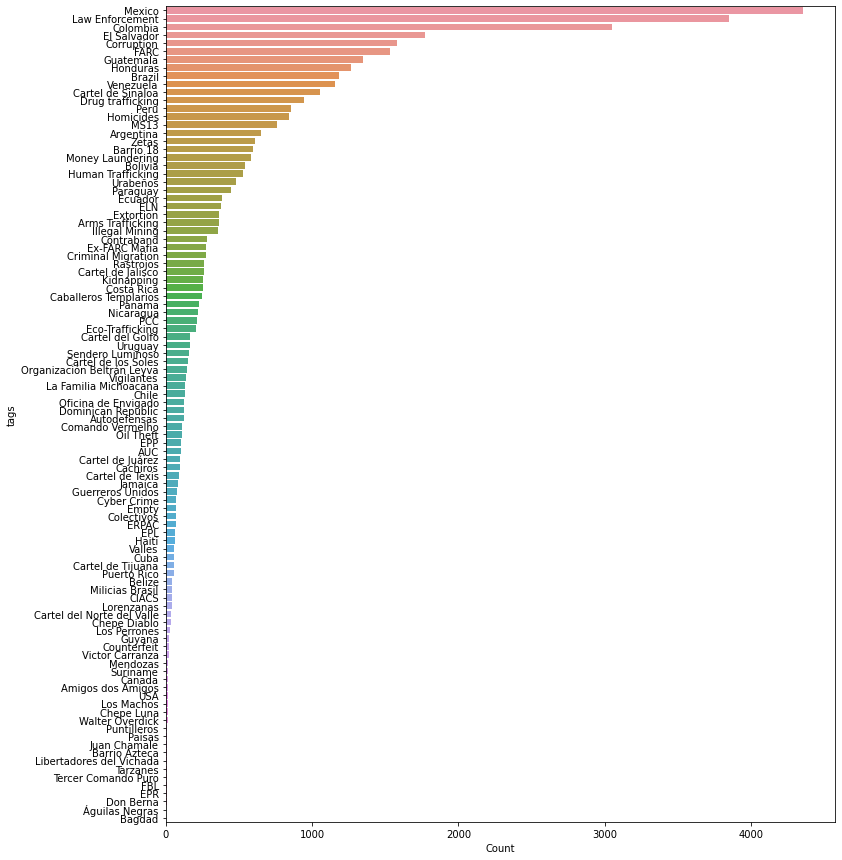

In [ ]:
g = all_tags_df.nlargest(columns="Count", n = 100) 
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=g, x= "Count", y = "tags") 
ax.set(ylabel = 'tags') 
plt.show()


Below is the dataframe we are working with, the content column is the text we will be working with.

In [ ]:
df.head()

,content,title,new_tags,tags,cats
0,Protests broke out in Bolivia last year in the...,Bolivia Investigations Target Members of Evo M...,"Corruption,Bolivia,Drug trafficking","Bolivia,Cocaine,Elites and Organized Crime,Inf...","[Corruption, Bolivia, Drug trafficking]"
1,Increased security of containers entering the ...,Can Port of Antwerp Truly Stem Cocaine Enterin...,"Brazil,Law Enforcement,Drug trafficking,Suriname","Brazil,Cocaine,European Organized Crime,Securi...","[Brazil, Law Enforcement, Drug trafficking, Su..."
2,The sight of children bearing arms in Guerrero...,Los Ardillos Continue Terrorizing Indigenous C...,"Mexico,Homicides","Homicides,Mexico","[Mexico, Homicides]"
3,Helena is one of the many former FARC members ...,Former FARC Guerrillas Recognized as Victims o...,"Colombia,FARC,FARC","Colombia,FARC,FARC peace,Gender and Organized ...","[Colombia, FARC, FARC]"
4,"Luis Del Río Jiménez, alias “el Tío,” or “Seño...",Was ‘Señor T’ One of Colombia’s Invisible Drug...,"Colombia,Corruption","Colombia,Elites and Organized Crime","[Colombia, Corruption]"


Here I define the process through which each article will be cleaned. I drop punctuations, white space, paragraphs, and convert everything to lower case.

I have not removed accents and I am not stemming or lemmatizing each word. We can discuss this approach to see if it will offer an advantage. 



In [ ]:
def clean_text(text):
    text = re.sub(r'[?|!|\'|"|#]',r'',text)
    text = re.sub(r'[.|,|)|(|\|/]',r' ',text)
    text = text.strip()
    text = text.replace("\n"," ")
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    #text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text

Let's produce a new column with clean_text

In [ ]:
df['clean_text'] = df['content'].apply(lambda x: clean_text(x))


Accents and numeric characters are still in the text. Let me know what you think of this. 

In [ ]:
df

,content,title,new_tags,tags,cats,clean_text
0,Protests broke out in Bolivia last year in the...,Bolivia Investigations Target Members of Evo M...,"Corruption,Bolivia,Drug trafficking","Bolivia,Cocaine,Elites and Organized Crime,Inf...","[Corruption, Bolivia, Drug trafficking]",protests broke out in bolivia last year in the...
1,Increased security of containers entering the ...,Can Port of Antwerp Truly Stem Cocaine Enterin...,"Brazil,Law Enforcement,Drug trafficking,Suriname","Brazil,Cocaine,European Organized Crime,Securi...","[Brazil, Law Enforcement, Drug trafficking, Su...",increased security of containers entering the ...
2,The sight of children bearing arms in Guerrero...,Los Ardillos Continue Terrorizing Indigenous C...,"Mexico,Homicides","Homicides,Mexico","[Mexico, Homicides]",the sight of children bearing arms in guerrero...
3,Helena is one of the many former FARC members ...,Former FARC Guerrillas Recognized as Victims o...,"Colombia,FARC,FARC","Colombia,FARC,FARC peace,Gender and Organized ...","[Colombia, FARC, FARC]",helena is one of the many former farc members ...
4,"Luis Del Río Jiménez, alias “el Tío,” or “Seño...",Was ‘Señor T’ One of Colombia’s Invisible Drug...,"Colombia,Corruption","Colombia,Elites and Organized Crime","[Colombia, Corruption]",luis del río jiménez alias “el tío ” or “señor...
...,...,...,...,...,...,...
15650,SHARE\nLa captura de Daniel “El Loco” Barrera ...,El arresto del ‘Loco Barrera’ muestra a Venezu...,"Venezuela,Rastrojos","El Loco Barrera,Venezuela","[Venezuela, Rastrojos]",share la captura de daniel “el loco” barrera e...
15651,SHARE\nEl informe\nelaborado por el inspector ...,Veredicto sobre la Operación ‘Rápido y Furioso’,"Mexico,Arms Trafficking","Frontera EU/México,Tráfico de armas","[Mexico, Arms Trafficking]",share el informe elaborado por el inspector ge...
15652,SHARE\nFalsos periodistas de la cadena Televis...,Falsos Periodistas Acusados por los Delitos de...,"Money Laundering,Costa Rica,Nicaragua","Costa Rica,Lavado de dinero,Nicaragua","[Money Laundering, Costa Rica, Nicaragua]",share falsos periodistas de la cadena televisa...
15653,"SHARE\nEn lo corrido del año, la Secretaría de...",Aproximadamente 8.000 Detenidos por Narcotráfi...,Mexico,México,[Mexico],share en lo corrido del año la secretaría de l...


Below I visualize common words in the text, useful for building a stopwords dictionary. 

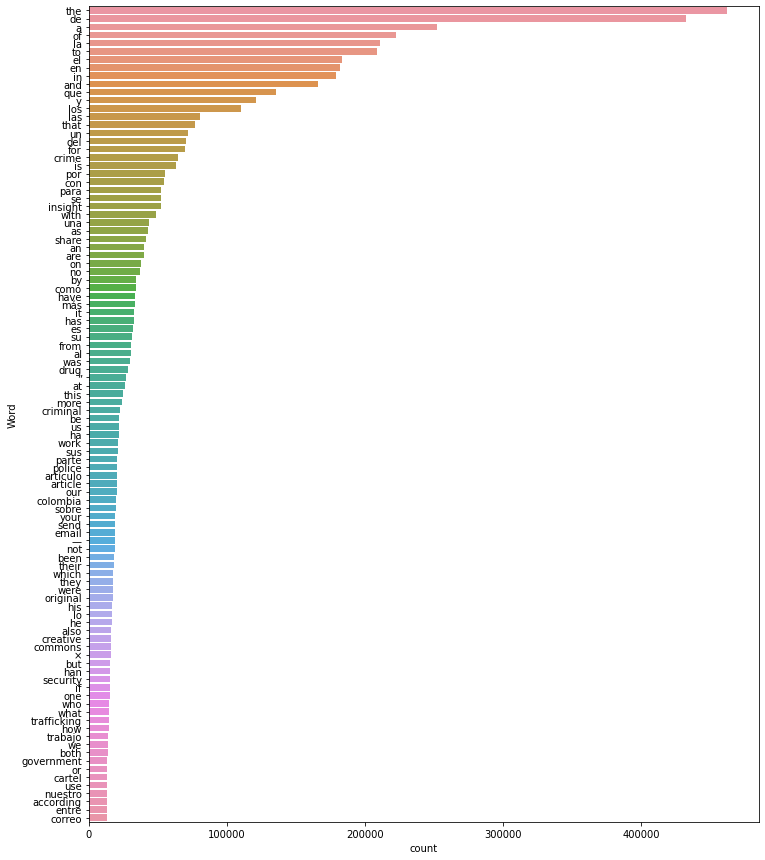

In [ ]:
def freq_words(x, terms = 30): 
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  fdist = nltk.FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # selecting top 20 most frequent words 
  d = words_df.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
  plt.figure(figsize=(12,15)) 
  ax = sns.barplot(data=d, x= "count", y = "word") 
  ax.set(ylabel = 'Word') 
  plt.show()
  
# print 100 most frequent words 
freq_words(df['clean_text'], 100)

Now let's drop stop words in english and spanish. 

---



In [ ]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
stop_words_es = set(stopwords.words("spanish"))
#stop_words_es

In [ ]:
new_words = ["share", "email", "correo", "insight", "creative", "commons", "link",
             "website", "x", "-", "electronico"]

I have not added custom stop words, but here is the spot they would go if we decide to exclude particular words. 

In [ ]:
stop_words = stop_words.union(stop_words_es)
stop_words = stop_words.union(new_words)
#stop_words

In [ ]:
# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

df['clean_text'] = df['clean_text'].apply(lambda x: remove_stopwords(x))

New frequency graph with the most common words without stop words. 

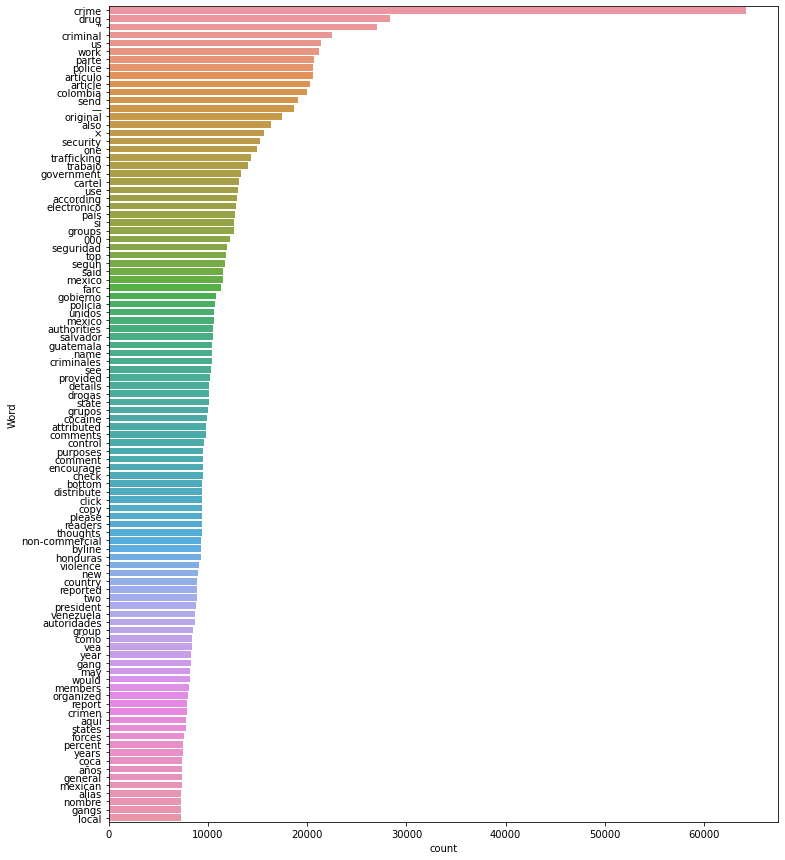

In [ ]:
freq_words(df['clean_text'], 100)


I'm going to save the df so that I can use it with Bert in a different script.

In [ ]:
df.to_csv("My Drive/Data/Insight Crime/models/data/Insight_Clean_07142020.csv")

## Machile Learning

Now we get to the fun stuff. I'm using multi label binarizer to convert our cats into binary indicators. 

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(df['cats'])

# transform target variable
y = multilabel_binarizer.transform(df['cats'])

In [ ]:
y

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
print((multilabel_binarizer.classes_))

['AUC' 'Amigos dos Amigos' 'Argentina' 'Arms Trafficking' 'Autodefensas'
 'Bagdad' 'Barrio 18' 'Barrio Azteca' 'Belize' 'Bolivia' 'Brazil' 'CIACS'
 'Caballeros Templarios' 'Cachiros' 'Calor Calor' 'Canada'
 'Cartel de Jalisco' 'Cartel de Juárez' 'Cartel de Sinaloa'
 'Cartel de Texis' 'Cartel de Tijuana' 'Cartel de los Soles'
 'Cartel del Golfo' 'Cartel del Norte del Valle' 'Chepe Diablo'
 'Chepe Luna' 'Chile' 'Colectivos' 'Colombia' 'Comando Vermelho'
 'Contraband' 'Corruption' 'Costa Rica' 'Counterfeit' 'Criminal Migration'
 'Cuba' 'Cyber Crime' 'Dominican Republic' 'Don Berna' 'Drug trafficking'
 'ELN' 'EPL' 'EPP' 'EPR' 'ERPAC' 'Eco-Trafficking' 'Ecuador' 'El Salvador'
 'Empty' 'Ex-FARC Mafia' 'Extortion' 'FARC' 'FBL' 'Francisco Zeledon'
 'Guatemala' 'Guerreros Unidos' 'Guyana' 'Haiti' 'Homicides' 'Honduras'
 'Human Trafficking' 'Illegal Mining' 'Jamaica' 'Juan Chamale'
 'Kidnapping' 'La Familia Michoacana' 'Law Enforcement' 'Leones'
 'Libertadores del Vichada' 'Lorenzanas' 'Los Capa

Here's what article 2 from above looks like after the encoding. Notice the 5 1's across the array. 

In [ ]:
y[1]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

I use TF-IDF to vectorize our content. Max features set to 10,000. This will help weigh properly common and sparse words. 

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)


Here is our second problem. As I mentioned earlier there are many categories with less than 10 mentions in the entire corpus. Thus there are examples where the model will simply not learn about a category because there are no examples in the training data if they get assigned to the test category.

To reduce this possibility I only leave 10% of articles for testing. The best approach would be to reduce the number of cats to a more reasonable number given the size of training data. 

In [ ]:
xtrain, xval, ytrain, yval = train_test_split(df['clean_text'], y, test_size=0.1, random_state=9)


In [ ]:
# create TF-IDF features
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)


Below we define the model. For this example a Logistic Regression is used and a One vs Rest Classifier to determine the relevance of each tag to the article. Thus, for each of the 105 cats it performs an LR and determines the probability of each cat being assigned that specific article, if above a .5 threshold then that is 1 of the labels assigned. This allows for multiple labels being assigned to a single document. 

In [ ]:
from sklearn.linear_model import LogisticRegression

# Binary Relevance
from sklearn.multiclass import OneVsRestClassifier

# Performance metric
from sklearn.metrics import f1_score

In [ ]:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

Let's fit the model. 

In [ ]:
# fit model on train data
clf.fit(xtrain_tfidf, ytrain)

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)

In [ ]:
# make predictions for validation set
y_pred = clf.predict(xval_tfidf)
y_score = clf.predict_proba(xval_tfidf)

Let's see what the model predicted for an article.

In [ ]:
y_pred[3]


array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

I'm not very good at reading binary so here's the predicted cats. 

In [ ]:
y_score[4]

array([4.49255724e-03, 7.02844084e-04, 7.25949714e-03, 4.93461906e-03,
       7.43974094e-01, 2.72048188e-04, 6.82688769e-03, 6.46052780e-04,
       1.68451966e-03, 6.09559918e-03, 1.31167733e-02, 1.82385561e-03,
       8.20675149e-02, 2.31232113e-03, 2.72048188e-04, 1.02741774e-03,
       2.51803632e-02, 3.65170815e-03, 1.13464801e-02, 2.85784461e-03,
       2.27120217e-03, 3.18588715e-03, 5.60642406e-03, 1.55650353e-03,
       1.23376836e-03, 7.68217720e-04, 2.77449404e-03, 2.23926893e-03,
       1.93733683e-02, 2.59925834e-03, 6.27209149e-03, 2.66342346e-02,
       3.62107799e-03, 1.61587691e-03, 6.86773340e-03, 2.29621576e-03,
       4.03356993e-03, 3.92984755e-03, 4.19809405e-04, 8.08030212e-03,
       3.30961728e-03, 1.54366283e-03, 2.08795688e-03, 4.39804979e-04,
       1.86194448e-03, 6.37175240e-03, 5.49996013e-03, 1.18623018e-02,
       3.48129546e-03, 3.14931988e-03, 1.37537472e-02, 7.53359415e-03,
       4.12372077e-04, 2.04181076e-04, 1.19953747e-02, 3.53748219e-03,
      

In [ ]:
y_trash = (y_score > 0.5)


In [ ]:
(y_trash[100])

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False])

In [ ]:
multilabel_binarizer.inverse_transform(y_pred)[100]


('Honduras', 'Law Enforcement')

And here are the actual cats, boom spot on!

In [ ]:
multilabel_binarizer.inverse_transform(yval)[1]


('Colombia', 'Drug trafficking')

Let's see what the micro-averaged f1 is. .74 which is farily good given the number of cats!

In [ ]:
f1_score(yval, y_pred, average="micro")


0.7459123610202748

In [ ]:
# Import Performance metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(yval, y_pred, target_names=multilabel_binarizer.classes_ ))

                            precision    recall  f1-score   support

                       AUC       1.00      0.15      0.27        13
         Amigos dos Amigos       0.00      0.00      0.00         5
                 Argentina       1.00      0.75      0.85        71
          Arms Trafficking       1.00      0.60      0.75        35
              Autodefensas       1.00      0.40      0.57        15
                    Bagdad       0.00      0.00      0.00         0
                 Barrio 18       0.70      0.54      0.61        59
             Barrio Azteca       0.00      0.00      0.00         1
                    Belize       0.00      0.00      0.00         9
                   Bolivia       0.92      0.67      0.78        49
                    Brazil       0.98      0.77      0.86       120
                     CIACS       0.00      0.00      0.00         2
     Caballeros Templarios       1.00      0.41      0.58        22
                  Cachiros       1.00      0.80

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The classification report above shows us how it did on specific categories. There are some that dont have enough observations. 

Now let's see how well it does on multiple articles and we'll ask it to print the title of the article for some context. 

In [ ]:
def infer_tags(q):
    q = clean_text(q)
    q = remove_stopwords(q)
    q_vec = tfidf_vectorizer.transform([q])
    q_pred = clf.predict(q_vec)
    return multilabel_binarizer.inverse_transform(q_pred)

In [ ]:
for i in range(5): 
  k = xval.sample(1).index[0] 
  print("Title: ", df['title'][k], "\nPredicted tags: ", infer_tags(xval[k])), print("Revised tags: ",df['cats'][k]),  print("Original tags: ",df['tags'][k], "\n")


Title:  Arrest of El Salvador ‘Pastor’ Points to Gangs’ Social Integration 
Predicted tags:  [('El Salvador', 'MS13')]
Revised tags:  ['El Salvador', 'MS13']
Original tags:  El Salvador,MS13 

Title:  Mexico’s Drug Lords: Too Big to Fail? 
Predicted tags:  [('Mexico',)]
Revised tags:  ['Colombia', 'Mexico', 'Cartel de Sinaloa', 'Caballeros Templarios']
Original tags:  Colombia,El Chapo,El Chayo,Mexico 

Title:  Questioning Ties Between Colombia Indigenous and FARC Rebels 
Predicted tags:  [('Colombia', 'FARC')]
Revised tags:  ['Colombia', 'FARC']
Original tags:  Colombia,FARC 

Title:  US Senate Caucus on International Narcotics Control: Responding to Violence in Central America 
Predicted tags:  [('El Salvador', 'Guatemala', 'Honduras')]
Revised tags:  ['El Salvador', 'Guatemala', 'Honduras', 'Costa Rica', 'Nicaragua', 'Panama', 'Belize']
Original tags:  Belize,Costa Rica,El Salvador,Guatemala,Honduras,Nicaragua,Panama 

Title:  Peru Issues ‘Red Alert’ for Capture of 90 Connected to F

So it looks like for some tags it has no difficulty, but for others it struggles. I think the .5 threshold for acceptances is kind of high given the overlap between some categories. 

I also think this is task is too large for a single classifier to handle. It would be better if we took a nested category approach. For example, articles about Cartels be assigned into a macro category of DTO's then within this category classify only those articles with potential DTO's. This simplifies the classification process for the algorithm and eliminates much of the noise hurting our scores. 

## Additional ML

Now I try a multi-label lazy approach taken from https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff



In [ ]:
!pip install scikit-multilearn


     |████████████████████████████████| 92kB 3.4MB/s 


Let's use a multi-label k-nearest neighbor algorithm. 

In [ ]:
import nltk

from skmultilearn.adapt import MLkNN
from scipy.sparse import csr_matrix, lil_matrix
classifier_new = MLkNN(k=10)
# Note that this classifier can throw up errors when handling sparse matrices.
x_train = lil_matrix(xtrain_tfidf).toarray()
y_train = lil_matrix(ytrain).toarray()
x_test = lil_matrix(xval_tfidf).toarray()
# train
classifier_new.fit(x_train, y_train)
# predict
predictions_new = classifier_new.predict(x_test)


Doesn't do very well. I haven't played around too much with it.

In [ ]:
from sklearn.metrics import accuracy_score

# accuracy
print("Accuracy = ",accuracy_score(yval,predictions_new))
print("\n")

## LDA Approach

Just to understand the data better I implement an LDA. 

In [ ]:
%tensorflow_version 1.15.0
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import decomposition
import numpy

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.15.0`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [ ]:
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(df['clean_text'])

# transform the training and validation data using count vectorizer object
xtrain_count =  count_vect.transform(xtrain)
#xvalid_count =  count_vect.transform(valid_x)

Below I use latent Dirichlet allocation to extract topic summaries for the entire data set. 

In [ ]:
# train a LDA Model
lda_model = decomposition.LatentDirichletAllocation(n_components=20, learning_method='online', max_iter=20)
X_topics = lda_model.fit_transform(xtrain_count)
topic_word = lda_model.components_ 
vocab = count_vect.get_feature_names()



In [ ]:
# view the topic models
n_top_words = 10
topic_summaries = []
for i, topic_dist in enumerate(topic_word):
    topic_words = numpy.array(vocab)[numpy.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))

Below I print out the topic summaries, to get an idea of what the text is about and to find any missing stopwords to add to the dictionary. 

In [ ]:
topic_summaries

['insight crime artículo parte trabajo electrónico correo share policía si',
 'miami cyber internet florida andrés online muerte santa patiño herald',
 'farc eln paz guerrilla ejército epl cuba antioquia santander desmovilización',
 's crime colombia insight us president also share drug former',
 'guatemala cicig morales guatemalan molina pérez lima odebrecht baldetti shining',
 'drug cocaine trafficking crime s insight share us colombia drugs',
 'costa rica cartel mining nicaragua cjng jalisco gold michoacan illegal',
 'drogas cocaína país ciento colombia parte crime insight artículo informe',
 'ecuador guerrero veracruz duarte iguala students estudiantes guerreros unidos 43',
 'salvador pandillas ms13 pandilleros barrio tregua pandilla 18 policía dos',
 'paraguay brazil pcc brasil rio paulo brazilian janeiro são comando',
 'argentina uruguay marihuana jamaica kirchner trinidad macri cannabis monos tobago',
 'carranza penn giuliani cultural york emerald church moreira mancuso catalino